In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df = pd.read_csv("customers.csv")

# quick look
df.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment_Method,Monthly_Charges,Total Charges,Churn,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1.0,86.0,3239.0,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.30742,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1.0,67.0,2701.0,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1.0,86.0,5372.0,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1.0,84.0,5003.0,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1.0,89.0,5340.0,Competitor had better devices


In [2]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         6970 non-null   object 
 1   Count              6970 non-null   int64  
 2   Country            6970 non-null   object 
 3   State              6970 non-null   object 
 4   City               6970 non-null   object 
 5   Zip Code           6970 non-null   object 
 6   Lat Long           6970 non-null   object 
 7   Latitude           6970 non-null   object 
 8   Longitude          6970 non-null   object 
 9   Gender             6970 non-null   object 
 10  Senior Citizen     6970 non-null   object 
 11  Partner            6970 non-null   object 
 12  Dependents         6970 non-null   object 
 13  Tenure             6970 non-null   float64
 14  Phone Service      6970 non-null   object 
 15  Multiple Lines     6970 non-null   object 
 16  Internet Service   6970 

,0
CustomerID,0
Count,0
Country,0
State,0
City,0
Zip Code,0
Lat Long,0
Latitude,0
Longitude,0
Gender,0


In [4]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

In [6]:
churn_rate = df['Churn'].value_counts(normalize=True) * 100
churn_rate

,proportion
Churn,
No,73.181231
Yes,26.818769


**The churn rate calculated in Python matches SQL outputs, validating results.**

Churn vs Contract Type

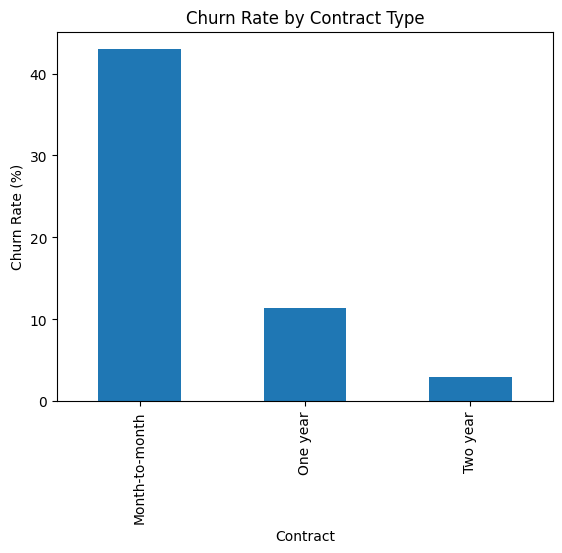

In [8]:
contract_churn = (
    df.groupby('Contract')['Churn']
    .value_counts(normalize=True)
    .unstack() * 100
)

contract_churn['Yes'].plot(kind='bar')
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Contract Type")
plt.show()

**Insights**:
*   Month-to-month contracts have highest churn
*   Long-term contracts stabilize customers

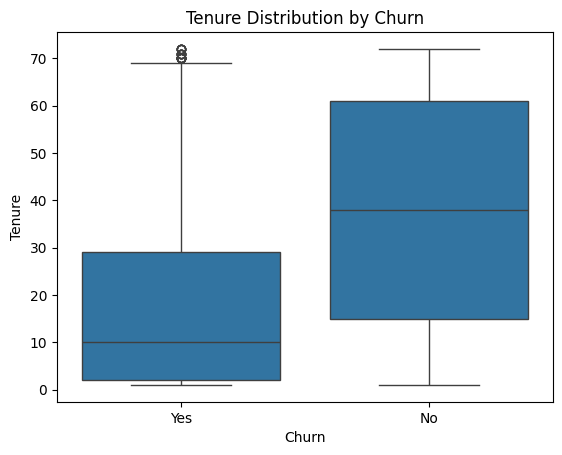

In [10]:
sns.boxplot(x='Churn', y='Tenure', data=df)
plt.title("Tenure Distribution by Churn")
plt.show()

**Insight**: Churned customers have significantly lower tenure.

Monthly Charges vs Churn

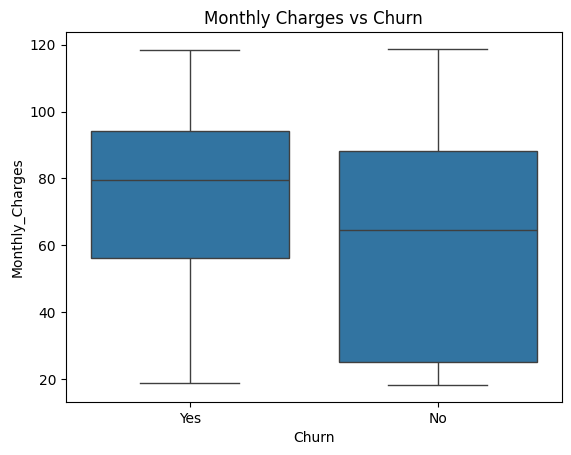

In [12]:
sns.boxplot(x='Churn', y='Monthly_Charges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

**Insights:**
*  Customers with higher monthly charges churn more
*  Pricing sensitivity exists


**Tenure Bucketing**

/tmp/ipython-input-3500744564.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('tenure_group')['Churn']


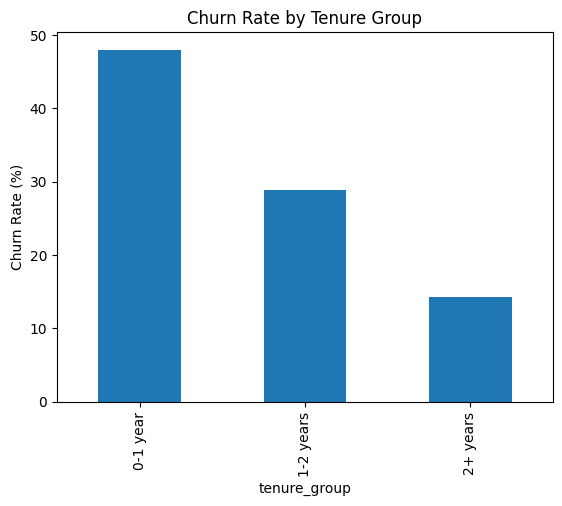

In [14]:
df['tenure_group'] = pd.cut(
    df['Tenure'],
    bins=[0,12,24,72],
    labels=['0-1 year','1-2 years','2+ years']
)

tenure_churn = (
    df.groupby('tenure_group')['Churn']
    .value_counts(normalize=True)
    .unstack() * 100
)

tenure_churn['Yes'].plot(kind='bar')
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Tenure Group")
plt.show()

**Revenue Leakage Analysis**

In [16]:
revenue_lost = df[df['Churn']=='Yes']['Monthly_Charges'].sum()
revenue_lost

np.float64(139130.85)

**Insight**: Churn is not evenly distributed — a small group of customers contributes disproportionately to revenue loss.

**High-Risk Customer Segment**

In [18]:
high_risk = (
    df[df['Churn']=='Yes']
    .groupby(['Contract','Payment_Method'])
    .agg(
        avg_monthly_charges=('Monthly_Charges','mean'),
        avg_tenure=('Tenure','mean'),
        count=('CustomerID','count')
    )
    .sort_values(by='avg_monthly_charges', ascending=False)
)

high_risk.head()

avg_monthly_charges  avg_tenure  count
Contract Payment_Method                                                   
Two year Bank transfer (automatic)            95.410526   63.368421     19
One year Electronic check                     91.043750   48.406250     64
Two year Electronic check                     88.180769   61.230769     13
One year Credit card (automatic)              86.454878   48.682927     41
         Bank transfer (automatic)            82.293421   45.210526     38

In [19]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=high_risk)

https://docs.google.com/spreadsheets/d/1bghw4hAcH3x63cm8TxbMUxsxDO9f6HspyE1ZJXyMGyQ/edit#gid=0
